In [1]:
import sys
sys.path.append("./../common/")
from utils import *
from config import *

In [2]:
def least_squares(x, y):
    phi = np.vstack([x, np.ones(N)]).T
    y = y[:, np.newaxis]

    w = np.dot((np.dot(np.linalg.inv(np.dot(phi.T, phi)), phi.T)),y)
    return tuple(w.squeeze())

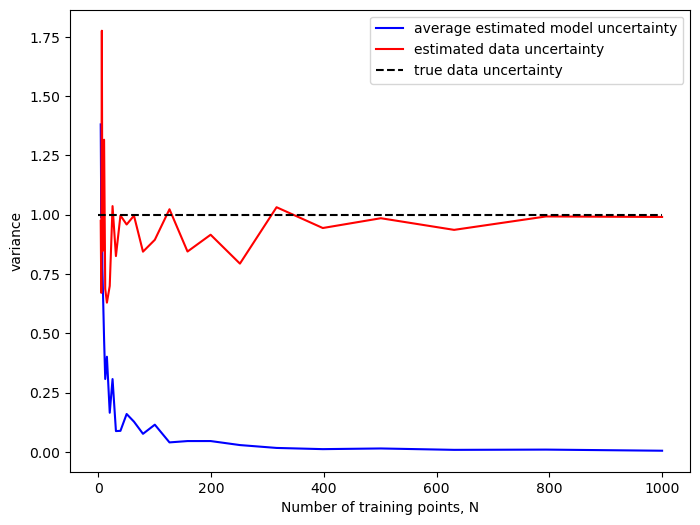

In [3]:
m, c = 2, 1
true_data_unc = 1
k = 10

Ns = np.geomspace(4, 1000, 25).astype(int)
data_uncs = []
model_uncs = []
for N in Ns:
    x = np.arange(0, N)
    y = (m * x) + c + np.random.normal(0, true_data_unc, N)

    # calculating data uncertainty using least squares
    m_hat, c_hat = least_squares(x, y)
    y_hat = (m_hat * x) + c_hat
    sd_data = np.std(y - y_hat)
    data_unc = sd_data ** 2
    data_uncs.append(data_unc)

    # calculating model uncertainty using bayesian treatment
    alpha = sd_data
    beta = 1/alpha**2
    phi = np.vstack([x, np.ones(N)]).T
    y = y[:, np.newaxis]
    I = np.identity(2)
    SN_inv = (alpha * I) + (beta * np.dot(phi.T, phi))
    SN = np.linalg.inv(SN_inv)
    mN = beta * np.dot(np.dot(SN, phi.T), y)
    
    m_hat, c_hat = tuple(mN.squeeze())
    sd_m, sd_c = np.sqrt(np.diag(SN))
    y_hats = []
    for _ in range(k):
        y_hat = (m_hat + np.random.normal(0, sd_m)) * x + (c_hat + np.random.normal(0, sd_c))
        y_hats.append(y_hat)
    model_unc = np.var(np.asarray(y_hats).squeeze(), 0).mean()
    model_uncs.append(model_unc)

fig = plt.figure()
plt.plot(Ns, model_uncs, c="blue", label="average estimated model uncertainty")
plt.plot(Ns, data_uncs, c="red", label="estimated data uncertainty")
plt.plot([0, np.max(Ns)], [true_data_unc, true_data_unc], '--', c = "black", label="true data uncertainty")
save_xy_graph(fig, "Number of training points, N", "variance", figures_dir, 'real_scenario_unc.png')